In [2]:
# Import dependencies
import os #using operating system dependent functionality
import csv
import zipfile #  read and write files in the ZIP archive format.
from io import BytesIO
from collections import defaultdict #Provides default values to immutable keys
import re #Extract particular data from string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# list IDs and labels

trainids=[]
labels=[]
with open('trainLabels.csv','r') as f:
    r=csv.reader(f)
    next(r) # Skip header
    for row in r:
        trainids.append(row[0])
        labels.append(int(row[1]))

testids=[]
with open('sampleSubmission.csv','r') as f:
    r=csv.reader(f)
    next(r)
    for row in r:
        testids.append(row[0])

In [13]:
len(testids), len(trainids), len(labels)

(10873, 10868, 10868)

In [96]:
# For less files
files = os.listdir('train/')
filenames=[]
for file in files:
    filenames.append(file.split('.')[0])

files1=os.listdir('test/')
filenames1=[]
for file in files1:
    filenames1.append(file.split('.')[0])


#trainids=testids
trainids=set(filenames) & set(trainids)

#testids=trainids
testids=set(filenames1) & set(testids)
print(len(trainids),len(testids))

500 500


In [4]:
print('Train')
a=list(trainids)
df_tr = pd.DataFrame({'Id':a})

print('\nTest')
b=list(testids)
df_te = pd.DataFrame({'Id':b})

Train

Test


In [5]:
df_tr.shape,df_te.shape

((10868, 1), (10873, 1))

In [6]:
df_tr.head(3)

,Id
0,01kcPWA9K2BOxQeS5Rju
1,04EjIdbPV5e1XroFOpiN
2,05EeG39MTRrI6VY21DPd


In [7]:
df=pd.read_csv('trainLabels.csv')
df_tr=pd.merge(df_tr,df, how='inner', on='Id')

#df1=pd.read_csv('sampleSubmission.csv')
#df_te=pd.merge(df_te,df1, how='inner', on='Id')

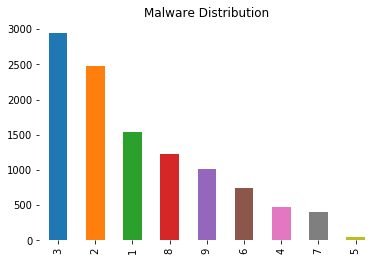

In [38]:
df_tr.Class.value_counts().plot(kind='bar')
plt.title('Malware Distribution')
plt.box(on=False)

### 1. General Functions

In [101]:
def readdata(fname,header=True,selectedcols=None):
    with open(fname,'r') as f:
        r=csv.reader(f)
        names = next(r) if header else None
        if selectedcols:
            assert header==True
            data = [[float(e) for i,e in enumerate(row) if names[i] in selectedcols] for row in r]
            names = [name for name in names if name in selectedcols]
        else:
            data = [[float(e) for e in row] for row in r]
    return data,names

def writedata(data,fname,header=None):
    with open(fname,'w') as f:
        w=csv.writer(f)
        if header:
            w.writerow(header)
        for row in data:
            w.writerow(row)

###  2. Extract File Properties

In [102]:
"""
function getcompressedsize
input: path to file
output: compressed size of file
* read file and compress it in memory
"""
def getcompressedsize(fpath):
    inMemoryOutputFile = BytesIO()
    zf = zipfile.ZipFile(inMemoryOutputFile, 'w') 
    zf.write(fpath, compress_type=zipfile.ZIP_DEFLATED) #Compression
    s = float(zf.infolist()[0].compress_size)
    zf.close()
    return s

In [103]:
"""
function writefileprops
input: ids of trainset or testset, string "train" or "test"
output: writes train_fileprops or test_fileprops
* extract file properties (size, compressed size, ratios) from all files in train or test set
"""
def writefileprops(ids,trainortest):
    with open('%s_fileprops.csv'%trainortest,'w',newline='') as f:
        w=csv.writer(f)
        w.writerow(['asmSize','bytesSize',
                    'asmCompressionRate','bytesCompressionRate',
                    'ab_ratio','abc_ratio','ab2abc_ratio'])
        for i in ids:
            asmsiz=float(os.path.getsize('%s/'%trainortest+i+'.asm'))
            bytsiz=float(os.path.getsize('%s/'%trainortest+i+'.bytes'))
            asmcr=getcompressedsize('%s/'%trainortest+i+'.asm')/asmsiz
            bytcr=getcompressedsize('%s/'%trainortest+i+'.bytes')/bytsiz
            ab=asmsiz/bytsiz
            abc=asmcr/bytcr
            w.writerow([asmsiz,bytsiz,asmcr,bytcr,ab,abc,ab/abc])
            f.flush()
        f.close()

### 3. Extract asm Contents

In [39]:
"""
the following three selections (on sections, dlls and opcodes) can be verified by looking
at the metadata files that are written during feature extraction. They are added here to
illustrate what the features mean, and to make the code more readible
"""

# sections that occur in at least 5 files from the trainset:
selsections=['.2', '.3', '.CRT', '.Lax503', '.Much', '.Pav', '.RDATA', '.Racy',
             '.Re82', '.Reel', '.Sty', '.Tls', '.adata', '.bas', '.bas0', '.brick',
             '.bss', '.code', '.cud', '.data', '.data1', '.edata', '.gnu_deb', '.hdata',
             '.icode', '.idata', '.laor', '.ndata', '.orpc', '.pdata', '.rata', '.rdat',
             '.rdata', '.reloc', '.rsrc', '.sdbid', '.sforce3', '.text', '.text1', '.tls',
             '.xdata', '.zenc', 'BSS', 'CODE', 'DATA', 'GAP', 'HEADER', 'Hc%37c',
             'JFsX_', 'UPX0', 'UPX1', 'Xd_?_mf', '_0', '_1', '_2', '_3',
             '_4', '_5', 'bss', 'code', 'seg000', 'seg001', 'seg002', 'seg003',
             'seg004']

# dlls that occur in at least 30 files from the trainset:
seldlls=['', '*', '2', '32', 'advapi32', 'advpack', 'api', 'apphelp',
         'avicap32', 'clbcatq', 'comctl32', 'comdlg32', 'crypt32', 'dbghelp', 'dpnet', 'dsound',
         'e', 'gdi32', 'gdiplus', 'imm32', 'iphlpapi', 'kernel32', 'libgcj_s', 'libvlccore',
         'mapi32', 'mfc42', 'mlang', 'mpr', 'msasn1', 'mscms', 'mscoree', 'msdart',
         'msi', 'msimg32', 'msvcp60', 'msvcp71', 'msvcp80', 'msvcr71', 'msvcr80', 'msvcr90',
         'msvcrt', 'msvfw32', 'netapi32', 'ntdll', 'ntdsapi', 'ntmarta', 'ntshrui', 'ole32',
         'oleacc', 'oleaut32', 'oledlg', 'opengl32', 'psapi', 'rasapi32', 'riched20', 'riched32',
         'rnel32', 'rpcrt4', 'rsaenh', 'secur32', 'security', 'sensapi', 'setupapi', 'shell32',
         'shfolder', 'shlwapi', 'tapi32', 'unicows', 'urlmon', 'user32', 'usp10', 'uxtheme',
         'version', 'wab32', 'wininet', 'winmm', 'wintrust', 'wldap32', 'ws2_32', 'wsock32',
         'xprt5']

# opcodes that occur in at least 30 files from the trainset:
selopcs=['aad', 'aam', 'adc', 'add', 'addpd', 'addps', 'addsd', 'align',
        'and', 'andnps', 'andpd', 'andps', 'arpl', 'assume', 'bound', 'bsf',
        'bsr', 'bswap', 'bt', 'btc', 'btr', 'bts', 'call', 'cmova',
        'cmovb', 'cmovbe', 'cmovg', 'cmovge', 'cmovl', 'cmovle', 'cmovnb', 'cmovns',
        'cmovnz', 'cmovs', 'cmovz', 'cmp', 'cmpeqsd', 'cmpltpd', 'cmps', 'cmpxchg',
        'db', 'dd', 'dec', 'div', 'divsd', 'dq', 'dt', 'dw',
        'end', 'endp', 'enter', 'fadd', 'faddp', 'fbld', 'fbstp', 'fcmovb',
        'fcmovbe', 'fcmove', 'fcmovnb', 'fcmovnbe', 'fcmovne', 'fcmovnu', 'fcmovu', 'fcom',
        'fcomi', 'fcomip', 'fcomp', 'fdiv', 'fdivp', 'fdivr', 'fdivrp', 'ffree',
        'ffreep', 'fiadd', 'ficom', 'ficomp', 'fidiv', 'fidivr', 'fild', 'fimul',
        'fist', 'fistp', 'fisttp', 'fisub', 'fisubr', 'fld', 'fldcw', 'fldenv',
        'fmul', 'fmulp', 'fnsave', 'fnstcw', 'fnstenv', 'fnstsw', 'frstor', 'fsave',
        'fst', 'fstcw', 'fstp', 'fstsw', 'fsub', 'fsubp', 'fsubr', 'fsubrp',
        'fucom', 'fucomi', 'fucomip', 'fucomp', 'fxch', 'hnt', 'hostshort',
        'ht', 'idiv', 'imul', 'in', 'inc', 'include', 'int', 'ja', 'jb', 'jbe',
        'jecxz', 'jg', 'jge', 'jl', 'jle', 'jmp', 'jnb', 'jno', 'jnp', 'jns',
        'jnz', 'jo', 'jp', 'js', 'jz', 'ldmxcsr', 'lds', 'lea', 'les', 'lock',
        'lods', 'loop', 'loope', 'loopne', 'mov', 'movapd', 'movaps', 'movd',
        'movdqa', 'movhps', 'movlpd', 'movlps', 'movq', 'movs', 'movsd', 'movss',
        'movsx', 'movups', 'movzx', 'mul', 'mulpd', 'mulps', 'mulsd', 'neg',
        'nop', 'not', 'offset', 'or', 'orpd', 'orps', 'out', 'outs', 'paddb',
        'paddd', 'paddq', 'paddsb', 'paddsw', 'paddusb', 'paddusw', 'paddw',
        'pand', 'pandn', 'pavgb', 'pcmpeqb', 'pcmpeqd', 'pcmpeqw', 'pcmpgtb',
        'pcmpgtd', 'pcmpgtw', 'pextrw', 'piconinfo', 'pinsrw', 'pmaddwd',
        'pmaxsw', 'pmulhw', 'pmullw', 'pop', 'por', 'pperrinfo', 'proc',
        'pshufd', 'pshufw', 'pslld', 'psllq', 'psllw', 'psrad', 'psraw',
        'psrld', 'psrlq', 'psrlw', 'psubb', 'psubd', 'psubq', 'psubsb',
        'psubsw', 'psubusb', 'psubusw', 'psubw', 'public', 'punpckhbw',
        'punpckhdq', 'punpckhwd', 'punpcklbw', 'punpckldq', 'punpcklwd',
        'push', 'pxor', 'rcl', 'rcpps', 'rcr', 'rep', 'repe', 'repne',
        'retf', 'retfw', 'retn', 'retnw', 'rgsabound', 'rol', 'ror', 'sal',
        'sar', 'sbb', 'scas', 'segment', 'setb', 'setbe', 'setl', 'setle',
        'setnb', 'setnbe', 'setnl', 'setnle', 'setns', 'setnz', 'seto',
        'sets', 'setz', 'shl', 'shld', 'shr', 'shrd', 'shufps', 'sldt',
        'stmxcsr', 'stos', 'sub', 'subpd', 'subps', 'subsd', 'test',
        'ucomisd', 'unicode', 'xadd', 'xchg', 'xlat', 'xor', 'xorpd', 'xorps']

In [49]:
print('Length selections, .dll extension and opcodes\n',len(selsections), len(seldlls), len(selopcs))

Length selections, .dll extension and opcodes
 65 81 280


In [50]:
"""
function getsectioncounts
input: list of lines in an asm file
output: dictionary with number of lines in each section
* count number of lines in each section
"""
def getsectioncounts(asmlines):
    sectioncounts=defaultdict(int)
    for l in asmlines:
        sectioncounts[l.split(':')[0]]+=1
    return sectioncounts

In [51]:
"""
function getcalls
input: list of lines in an asm file
output: dictionary with number of times each function is found
* count number of times each function occurs
"""
def getcalls(asmlines):
    calls=defaultdict(int)
    for l in asmlines:
        ls=l.split('__stdcall ')
        if len(ls)>1:
            calls[ls[1].split('(')[0]]+=1
    return calls

In [52]:
"""
function getdlls
input: list of lines in an asm file
output: dictionary with number of times each dll is found
* count number of times each dll occurs
"""
def getdlls(asmlines):
    dlls=defaultdict(int)
    for l in asmlines:
        ls=l.lower().split('.dll')
        if len(ls)>1:
            dlls[ls[0].replace('\'',' ').split(' ')[-1].split('"')[-1].split('<')[-1].split('\\')[-1].split('\t')[-1]]+=1
    return dlls

In [53]:
"""
function getopcodeseries
input: list of lines in an asm file
output: series of opcodes in the order in which they occur
* extract all opcodes using regular expressions
* first used to create opcode ngrams, but later translated to counts using series2freqs
"""
def getopcodeseries(asmlines):
    ops=[]
    opex=re.compile('(   )([a-z]+)( )')
    for l in asmlines:
        e=opex.search(l)
        if e:
            ops.append(e.group(2))
    return ops

def series2freqs(series):
    freqs=defaultdict(int)
    for e in series:
        freqs[e]+=1
    return freqs

In [54]:
"""
function getqperc
input: list of lines in an asm file
output: percent of characters that is a questionmark
* count number of questionmarks and divide it by number of characters
"""
def getqperc(asmlines):
    n=0
    nq=0
    for l in asmlines:
        for c in l:
            n+=1
            if c=='?':
                nq+=1
    return float(nq)/n

In [55]:
"""
function countbysection
input: list of lines in an asm file, list of sections to include, 
list of characters to include
output: number of occurences of each specified character by section, 
list of feature names, list of characters included
* count number of occurences of each specified character by section
"""
def countbysection(asmlines,segms,chars=[' ','?','.',',',':',';','+','-','=','[','(','_','*','!','\\','/','\''],namesonly=False):
    names=['%s_tot'%ss for ss in selsections]
    for c in chars:
        names.extend(['%s_c%s'%(ss,c) for ss in selsections])
    if namesonly:
        return names+['restsegm']+['%s_restchar'%ss for ss in selsections]
    ns=len(segms)
    nc=len(chars)
    segmdict={e:i for i,e in enumerate(segms)}
    chardict={e:i for i,e in enumerate(chars)}
    counts=[0 for i in range((nc+1)*ns)]
    for l in asmlines:
        segm=l.split(':')[0]
        if segm in segmdict:
            s=segmdict[segm]
            for ch in l:
                counts[s]+=1
                if ch in chardict:
                    c=chardict[ch]
                    counts[ns+c*ns+s]+=1
    return counts,names,chars

In [56]:
"""
function normalizecountbysection
input: output of function countbysection
output: normalized number of occurences of each specified character by section
* divide number of occurences of each specified character by section by total number
* and calculate rest percent of other characters and other sections
"""
def normalizecountbysection(counts,names,chars):
    d={names[i]:counts[i] for i in range(len(names))}
    tot=sum([d['%s_tot'%s] for s in selsections])
    d['restsegm']=1.0
    for s in selsections:
        d['%s_restchar'%s]=0.0
        if d['%s_tot'%s] > 0:
            d['%s_restchar'%s]=1.0
            for c in chars:
                d['%s_c%s'%(s,c)]=float(d['%s_c%s'%(s,c)])/d['%s_tot'%s]
                d['%s_restchar'%s]-=d['%s_c%s'%(s,c)]
            d['%s_tot'%s]=float(d['%s_tot'%s])/tot
            d['restsegm']-=d['%s_tot'%s]
    return [d[name] for name in names+['restsegm']+['%s_restchar'%ss for ss in selsections]]

In [57]:
"""
function writeasmcontents
input: ids of trainset or testset, string "train" or "test"
output: writes train_asmcontents or test_asmcontents + metadata on sections, 
calls, dlls and opcodes
* extract features from contents of asm from all files in train or test set
* by reading list of asm lines from each file and calling the previous functions
"""
def writeasmcontents(ids,trainortest):
    with open('%s_asmcontents.csv'%trainortest,'w',newline='') as f:
    #with open('%s_asmcontents.csv'%trainortest,'w') as f:
        w=csv.writer(f)
        w.writerow(
            ['sp_%s'%key for key in selsections]
            +['dl_%s'%key for key in seldlls]
            +['op_%s'%key for key in selopcs]
            +['qperc']
            +countbysection(None,selsections,namesonly=True)
            )
        fsec=open('secmetadata%s.txt'%trainortest,'w')
        wsec=csv.writer(fsec)
        fcal=open('calmetadata%s.txt'%trainortest,'w')
        wcal=csv.writer(fcal)
        fdll=open('dllmetadata%s.txt'%trainortest,'w')
        wdll=csv.writer(fdll)
        fopc=open('opcmetadata%s.txt'%trainortest,'w')
        wopc=csv.writer(fopc)
        for i in ids:
            with open('%s/'%trainortest+i+'.asm','r') as fasm:
                asmlines=[line for line in fasm.readlines()]
            # section counts/ proportions
            sc=getsectioncounts(asmlines)
            wsec.writerow([i]+['%s:%s'%(key,sc[key]) for key in sc if sc[key]>0])
            scsum=sum([sc[key] for key in sc])
            secfeat=[float(sc[key])/scsum for key in selsections]
            # calls
            cal=getcalls(asmlines)
            wcal.writerow([i]+['%s:%s'%(key,cal[key]) for key in cal if cal[key]>0])
            # dlls
            dll=getdlls(asmlines)
            wdll.writerow([i]+['%s:%s'%(key,dll[key]) for key in dll if dll[key]>0])
            dllfeat=[float(dll[key]) for key in seldlls]
            # opcodes
            opc=series2freqs(getopcodeseries(asmlines))
            wopc.writerow([i]+['%s:%s'%(key,opc[key]) for key in opc if opc[key]>0])
            opcfeat=[float(opc[key]) for key in selopcs]
            # overall questionmark proportion
            qperc=getqperc(asmlines)
            # normalized interpunction characters by section
            ipbysecfeat=normalizecountbysection(*countbysection(asmlines,selsections))
            #
            w.writerow(secfeat+dllfeat+opcfeat+[qperc]+ipbysecfeat)
            f.flush()
        fsec.close()
        fcal.close()
        fdll.close()
        fopc.close()

Reduce asm contents features, using a criterion on the number of files with nonzero value

In [58]:
"""
function writeasmcontents
input: traindata matrix, testdata matrix, feature names, criterion on required number of nonzeros in each column
output: reduced traindata matrix, testdata matrix and feature names
* calculate number of nonzeros by column and keep only features that meet the criterion
"""
def reducefeatures(xtrain,xtest,names,ncrit=100):
    ntrain=np.sum(np.array([np.array([ei!=0 for ei in e]) for e in xtrain]),axis=0)
    xtrain=np.array([np.array([e[j] for j,n in enumerate(ntrain) if n>ncrit]) for e in xtrain])
    xtest=np.array([np.array([e[j] for j,n in enumerate(ntrain) if n>ncrit]) for e in xtest])
    names=[names[j] for j,n in enumerate(ntrain) if n>ncrit]
    return xtrain,xtest,names

In [59]:
"""
function reduceasmcontents
input: none
output: write reduced asm contents
* read features on asm contents, reduce them by calling reducefeatures and write the results
"""
def reduceasmcontents():
    train_asmcontents,asmcontentshead=readdata('train_asmcontents.csv')
    test_asmcontents,_=readdata('test_asmcontents.csv')
    train_asmcontents_red,test_asmcontents_red,asmcontentshead_red=reducefeatures(
                                        train_asmcontents,test_asmcontents,asmcontentshead)
    writedata(train_asmcontents_red,'train_asmcontents_red.csv',asmcontentshead_red)
    writedata(test_asmcontents_red,'test_asmcontents_red.csv',asmcontentshead_red)

Calculate Statistics on asm Metadata

In [115]:
"""
function loadmetadata
input: path of metadatafile (written by writeasmcontents)
output: dictionary with metadata
* load metadata into dictionary
"""
def loadmetadata(inpath):
    md={}
    #print (md)
    with open(inpath,'r') as f:
        r=csv.reader(f)
        for row in r:
            print(row)
            md[tuple(row)]=defaultdict(int)
            for e in row[1:]:
                key,value=e.split(':')[-2:]
                md[tuple(row)][key]=int(value)
    return md

In [116]:
"""
function loadmetadata
input: path of metadatafile (written by writeasmcontents)
output: dictionary with metadata
* load metadata into dictionary
"""
def loadmetadata(inpath):
    md={}
    print (md)
    with open(inpath,'r') as f:
        r=csv.reader(f)
        for row in r:
            print(row)
            md[row[0]]=defaultdict(int)
            for e in row[1:]:
                key,value=e.split(':')[-2:]
                md[row[0]][key]=int(value)
    return md

In [117]:
"""
function getstats
input: metadata dictionary, dictionary keys sorted by number of occurrences 
over train and test set, type of metadata (sec[tions], dll[s], cal[ls] or 
opc[odes])
output: statistics on the specified type of metadata
* calculate statistics on the specified type of metadata
"""
def getstats(dct,sortedkeys,datatype):
    stats={}
    for i in dct:
        stats[i]={}
        d=dct[i]
        n=len(d)
        sm=sum([d[key] for key in d]) if n>0 else 0
        pmx=100*max([d[key] for key in d])/sm if n>0 else 0
        stats[i]['%s_nkey'%datatype]=n
        stats[i]['%s_sum'%datatype]=sm
        stats[i]['%s_pmax'%datatype]=pmx
        top5={key for key in sortedkeys[:5]}
        top20={key for key in sortedkeys[:20]}
        top50={key for key in sortedkeys[:50]}
        stats[i]['%s_n5key'%datatype]=len([e for e in d if e in top5])
        stats[i]['%s_n20key'%datatype]=len([e for e in d if e in top20])
        stats[i]['%s_n50key'%datatype]=len([e for e in d if e in top50])
    return stats

In [118]:
"""
function getstatsfromdata
input: type of metadata (sec[tions], dll[s], cal[ls] or opc[odes])
output: statistics on the specified type of metadata for both trainset and 
testset
* for each value, count the number of occurrences over train and test set
* call getstats to calculate statistics for each file
"""
def getstatsfromdata(datatype):
    traindict=loadmetadata('%smetadatatrain.txt'%datatype)
    testdict=loadmetadata('%smetadatatest.txt'%datatype)
    allkeys=defaultdict(int)
    for i in traindict:
        for key in traindict[i]:
            allkeys[key]+=1
    for i in testdict:
        for key in testdict[i]:
            allkeys[key]+=1       
    sortedkeys=sorted([key for key in allkeys],reverse=True,key=lambda x: allkeys[x])
    trainstats=getstats(traindict,sortedkeys,datatype)
    teststats=getstats(testdict,sortedkeys,datatype)
    return trainstats,teststats

In [119]:
"""
function writeasmstats
input: feature types (use only default; why is this a parameter??? I don't remember)
output: writes asm statistics to files for both train and test set
* call getstatsfromdata to calculate statistics on sec[tions], dll[s], cal[ls] and opc[odes]
* write the results to train_asmstats and test_asmstats
"""
def writeasmstats(stats=['nkey', 'sum', 'pmax', 'n5key', 'n20key', 'n50key']):
    traindata=[[] for i in range(len(trainids))]
    testdata=[[] for i in range(len(testids))]
    names=[]
    for datatype in ['sec','dll','cal','opc']:
        keys=['%s_%s'%(datatype,stat) for stat in stats]
        print('KEYS ARE', keys)
        trainstats,teststats=getstatsfromdata(datatype)
        print('Train Stats',trainstats)
        print('Test Stats',teststats)
        for inum,i in enumerate(trainids):
            traindata[inum].extend([trainstats[i][key] for key in keys])
        for inum,i in enumerate(testids):
            testdata[inum].extend([teststats[i][key] for key in keys])
        names.extend(keys)
    writedata(traindata,'train_asmstats.csv',names)
    writedata(testdata,'test_asmstats.csv',names)

### 4. Extract Bytes Contents

In [120]:
"""
function getcompressedsize_str
input: string
output: compressed size of string
* compress string and return the compressed size
"""
def getcompressedsize_str(strinput):
    inMemoryOutputFile = BytesIO()
    zf = zipfile.ZipFile(inMemoryOutputFile, 'w')
    zf.writestr('',strinput, compress_type=zipfile.ZIP_DEFLATED)
    return zf.infolist()[0].compress_size

In [121]:
"""
function writeblocksizes
input: ids of trainset or testset, string "train" or "test"
output: writes train_blocksizes or test_blocksizes
* calculate and write compressed size of each 4 kB block for all files in train or test set
"""
def writeblocksizes(ids,trainortest,blocksize=256): # 256 times 16 bytes = 4096 bytes
    with open('%s_blocksizes.csv'%trainortest,'w') as fout:
        for i in ids:
            with open('%s/%s.bytes'%(trainortest,i),'r') as fin:
                contents=fin.readlines()
            fout.write('%s,'%i)
            n=len(contents)
            blocksize=256 
            nblock=n/256
            for b in range(int(nblock)):
                strinput=''
                for lidx in range(b*blocksize,(b+1)*blocksize):
                    l=contents[lidx]
                    strinput += l[l.find(' ')+1:-1]
                s=getcompressedsize_str(strinput)
                fout.write('%d,'%s)
            fout.write('\n')

In [122]:
"""
function writeblocksizedistributions
input: string "train" or "test"
output: writes train_blocksizedistributions or test_blocksizedistributions
* calculate statistics on files with blocksizes to get the same number of features for each file
"""
def writeblocksizedistributions(trainortest):
    with open('%s_blocksizes.csv'%trainortest,'r') as f:
        with open('%s_blocksizedistributions.csv'%trainortest,'w') as fout:
            fout.write('cs4k_min,cs4k_p10,cs4k_p20,cs4k_p30,cs4k_p50,cs4k_p70,cs4k_p80,cs4k_p90,cs4k_max,cs4k_mean,cs4k_q1mean,cs4k_q2mean,cs4k_q3mean,cs4k_q4mean\n')
            for i,l in enumerate(f):
                ls=l.split(',')
                sizes=[float(e) for e in ls[1:-1]]
                slen=len(sizes)
                qlen=1 if slen/4<1 else slen/4
                q1m=np.mean(sizes[:qlen])
                q2m=np.mean(sizes[qlen:2*qlen])
                q3m=np.mean(sizes[-2*qlen:-qlen])
                q4m=np.mean(sizes[-qlen:])
                sizes=sorted(sizes)
                maxidx=slen-1
                fout.write('%.0f,%.0f,%.0f,%.0f,%.0f,%.0f,%.0f,%.0f,%.0f,%.0f,%.0f,%.0f,%.0f,%.0f\n'%(
                    sizes[0],
                    sizes[10*maxidx//100],
                    sizes[20*maxidx//100],
                    sizes[30*maxidx//100],
                    sizes[50*maxidx//100],
                    sizes[70*maxidx//100],
                    sizes[80*maxidx//100],
                    sizes[90*maxidx//100],
                    sizes[-1],
                    round(np.mean(sizes)),
                    q1m,q2m,q3m,q4m))

In [123]:
"""
function writecombifile
input: list of lists with 2 entries: file name and optional feature names (None for all), filename to write results to
output: writes file with combined feature sets
* combine features from different sets into a single file
* ids, labels and header are optional
"""
def writecombifile(sourcefilesandselections,filename,includeid=True,includelabel=True,header=True):
    nsource=len(sourcefilesandselections)
    for trainortest in ['train','test']:
        alldata=[]
        allnames=[]
        for source,selection in sourcefilesandselections:
            data,names=readdata('%s_%s'%(trainortest,source),selectedcols=selection)
            alldata.append(data)
            allnames.extend(names)
        with open('%s_%s'%(trainortest,filename),'w') as f:
            w=csv.writer(f)
            if header:
                w.writerow((['Id'] if includeid else [])+
                            allnames+
                            (['Class'] if includelabel else []))
            ids = trainids if trainortest=='train' else testids
            for inum,i in enumerate(ids):
                datarow=[]
                for src in range(nsource):
                    datarow.extend(alldata[src][inum])
                w.writerow(
                    ([i] if includeid else [])+
                    datarow+
                    ([labels[inum] if trainortest=='train' else -1] if includelabel else []))

### 1. File Properties Features

In [126]:
import time

start = time.time()
writefileprops(trainids,'train')
#writefileprops(testids,'test')

end = time.time()
print('Extraction for {} files took {} seconds'.format(len(trainids)*2,(end - start)))

Extraction for 1000 files took 240.54306650161743 seconds


### 2. ASM Contents Features

In [127]:
writeasmcontents(trainids,'train')
#writeasmcontents(testids,'test')

#### Reduced Features

In [131]:
reduceasmcontents()

In [135]:
data=pd.read_csv('train_asmcontents_red.csv')
print(data.shape)
data['Class']=df_tr.Class
data.shape

(500, 185)


(500, 186)

### Modeling

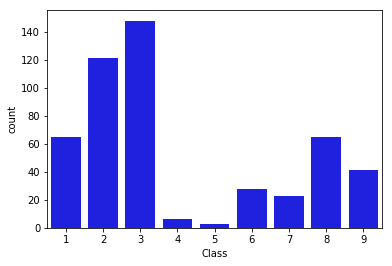

In [139]:
import seaborn as sns
sns.countplot(df_tr.Class,color='#0000FF')

In [363]:
X=data.iloc[:,:-1] # Train
y=data.Class # Test

In [364]:
X.columns = np.arange(len(X.columns))

In [365]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [252]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_score,confusion_matrix, recall_score, accuracy_score, log_loss

### 1. Extra Trees Classifier

In [263]:
et=ExtraTreesClassifier(n_estimators=100)
et.fit(X_train, y_train)

et_acc=accuracy_score(y_test, et.predict(X_test))
et_pr=precision_score(y_test, et.predict(X_test),average='micro') 
et_f1=f1_score(y_test, et.predict(X_test),average='micro') 
et_rc=recall_score(y_test, et.predict(X_test),average='micro') 
et_log=log_loss(y_test,et.predict_proba(X_test))

### 2. Random Forest

In [264]:
rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

rf_acc=accuracy_score(y_test, rf.predict(X_test))
rf_pr=precision_score(y_test, rf.predict(X_test),average='micro') 
rf_f1=f1_score(y_test, rf.predict(X_test),average='micro') 
rf_rc=recall_score(y_test, rf.predict(X_test),average='micro') 
rf_log=log_loss(y_test,rf.predict_proba(X_test))

### 3. XGBoost

In [265]:
xgb = XGBClassifier(n_estimators=150)
xgb.fit(X_train, y_train)
xgb_acc=accuracy_score(y_test, xgb.predict(X_test))
xgb_pr=precision_score(y_test, xgb.predict(X_test),average='micro') 
xgb_f1=f1_score(y_test, xgb.predict(X_test),average='micro') 
xgb_rc=recall_score(y_test, xgb.predict(X_test),average='micro') 
xgb_log=log_loss(y_test,xgb.predict_proba(X_test))

C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future

In [266]:
results=pd.DataFrame({'Algorithm':['Extra Trees','Random Forest', 'XGBoost'],
                     'Accuracy':[et_acc, rf_acc, xgb_acc],
                     'Precision':[et_pr, rf_pr, xgb_pr],
                     'Recall':[et_rc, rf_rc, xgb_rc],
                     'F1-Score':[et_f1, rf_f1, xgb_f1],
                     'Log Loss':[et_log,rf_log,xgb_log]})
results.set_index('Algorithm', inplace=True)
results

,Accuracy,Precision,Recall,F1-Score,Log Loss
Algorithm,,,,,
Extra Trees,0.976,0.976,0.976,0.976,0.632562
Random Forest,0.960,0.960,0.960,0.960,0.168815
XGBoost,0.968,0.968,0.968,0.968,0.126196


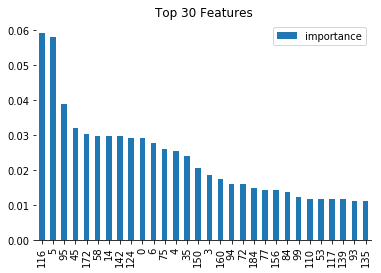

In [271]:
feature_importances = pd.DataFrame(xgb.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances[:30].plot(kind='bar', title='Top 30 Features')
sns.despine(left=True)

In [282]:
def selectKImportance(model, X, k=5):
     return X.iloc[:,model.feature_importances_.argsort()[::-1][:k]]

In [283]:
newX = selectKImportance(rf,X,50)
X_train, X_test, y_train, y_test = train_test_split(newX, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [285]:
xgb = XGBClassifier(n_estimators=150)
xgb.fit(X_train, y_train)
xgb_acc=accuracy_score(y_test, xgb.predict(X_test))
xgb_pr=precision_score(y_test, xgb.predict(X_test),average='micro') 
xgb_f1=f1_score(y_test, xgb.predict(X_test),average='micro') 
xgb_rc=recall_score(y_test, xgb.predict(X_test),average='micro') 
xgb_log=log_loss(y_test,xgb.predict_proba(X_test))
results1=pd.DataFrame({'Algorithm':['XGBoost'],
                     'Accuracy':[xgb_acc],
                     'Precision':[xgb_pr],
                     'Recall':[xgb_rc],
                     'F1-Score':[xgb_f1],
                     'Log Loss':[xgb_log]})
results1.set_index('Algorithm', inplace=True)
results1

C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future

,Accuracy,Precision,Recall,F1-Score,Log Loss
Algorithm,,,,,
XGBoost,0.976,0.976,0.976,0.976,0.097678


In [350]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
       
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))

    
    labels = ['Ramnit','Lollipop','Kelihos_ver3','Vundo','Simda',
                        'Tracur','Kelihos_ver1','Obfuscator.ACY','Gatak']
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("Confusion matrix")
    plt.figure(figsize=(7,4))
    sns.heatmap(C, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Number of misclassified points  2.4
Confusion matrix


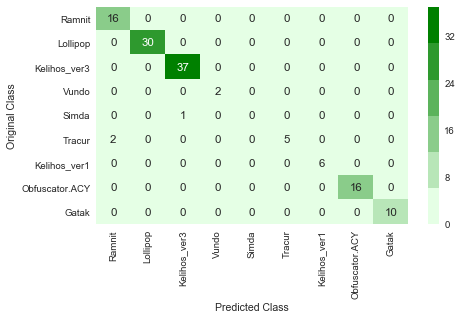

In [351]:
from sklearn.metrics import confusion_matrix
pred1=xgb.predict(X_test)

cf1=confusion_matrix(y_test, pred1)
plot_confusion_matrix(y_test, pred1)

### Principal Component Analysis

In [392]:
from sklearn.decomposition import PCA,KernelPCA
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
X_pca = scaler.fit_transform(X)

In [358]:
pca = PCA()
pca.fit(X_pca)
exp_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.zeros(exp_var_ratio.shape)
for i in range(len(cumulative_var_ratio)):
    cumulative_var_ratio[i] = np.sum(exp_var_ratio[0:i+1])
exp_var_ratio = np.concatenate((exp_var_ratio.reshape(1,len(exp_var_ratio)), cumulative_var_ratio.reshape(1,len(cumulative_var_ratio))), axis=0)
pd.set_option('display.max_columns', 100)
display(pd.DataFrame(exp_var_ratio, columns = ['PC_'+str(i+1) for i in range(X_pca.shape[1])], index = ['Proportion of variance', 'Cumulative proportion']))

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33,PC_34,PC_35,PC_36,PC_37,PC_38,PC_39,PC_40,PC_41,PC_42,PC_43,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50,...,PC_136,PC_137,PC_138,PC_139,PC_140,PC_141,PC_142,PC_143,PC_144,PC_145,PC_146,PC_147,PC_148,PC_149,PC_150,PC_151,PC_152,PC_153,PC_154,PC_155,PC_156,PC_157,PC_158,PC_159,PC_160,PC_161,PC_162,PC_163,PC_164,PC_165,PC_166,PC_167,PC_168,PC_169,PC_170,PC_171,PC_172,PC_173,PC_174,PC_175,PC_176,PC_177,PC_178,PC_179,PC_180,PC_181,PC_182,PC_183,PC_184,PC_185
Proportion of variance,0.431398,0.165596,0.080682,0.070548,0.047143,0.030941,0.027323,0.020050,0.014869,0.01437,0.009547,0.007227,0.006733,0.005180,0.004606,0.004065,0.003805,0.003199,0.002950,0.002804,0.002449,0.002191,0.002108,0.002079,0.001981,0.001853,0.001776,0.001634,0.001511,0.001429,0.001279,0.001241,0.001165,0.001129,0.001071,0.001023,0.001004,0.000924,0.000891,0.000865,0.000817,0.000808,0.000746,0.000739,0.000679,0.000640,0.000626,0.000618,0.000587,0.000570,...,0.000003,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000001,0.000001,0.000001,0.000001,9.318237e-07,8.003664e-07,6.849853e-07,6.283845e-07,4.960839e-07,4.328687e-07,3.194721e-07,2.966943e-07,2.062899e-07,1.486432e-07,2.127316e-08,4.556661e-10,5.297286e-11,1.492153e-16,2.821855e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33,1.839259e-33
Cumulative proportion,0.431398,0.596994,0.677676,0.748224,0.795366,0.826307,0.853631,0.873681,0.888550,0.90292,0.912467,0.919694,0.926427,0.931607,0.936213,0.940278,0.944083,0.947282,0.950232,0.953036,0.955485,0.957675,0.959783,0.961862,0.963843,0.965696,0.967472,0.969106,0.970616,0.972045,0.973324,0.974565,0.975730,0.976859,0.977930,0.978953,0.979957,0.980881,0.981772,0.982637,0.983454,0.984262,0.985008,0.985747,0.986426,0.987066,0.987692,0.988310,0.988898,0.989468,...,0.999976,0.999979,0.999981,0.999983,0.999985,0.999987,0.999989,0.999990,0.999992,0.999993,0.999994,0.999995,9.999960e-01,9.999968e-01,9.999974e-01,9.999981e-01,9.999986e-01,9.999990e-01,9.999993e-01,9.999996e-01,9.999998e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


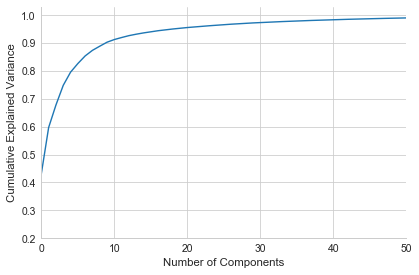

In [360]:
pca = PCA().fit(X_pca)
#fig, ax = plt.subplots()

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", font_scale=1.3)  
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)
#ax.grid(linestyle='-', linewidth='0.2', color='black')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');
axes = plt.gca()
axes.set_xlim([0,50])
axes.set_ylim([0.2,1.03])
plt.tight_layout()
sns.despine(top=True)
plt.savefig('Fig1.png', dpi=300)

In [402]:
X=data.iloc[:,:-1] # Train
y=data.Class # Test
X.columns = np.arange(len(X.columns))

#from sklearn.preprocessing import MinMaxScaler
#sc = MinMaxScaler(feature_range=(0,1))

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test) 

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

In [403]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)  

In [404]:
xgb = XGBClassifier(n_estimators=150)
xgb.fit(X_train, y_train)
xgb_acc=accuracy_score(y_test, xgb.predict(X_test))
xgb_pr=precision_score(y_test, xgb.predict(X_test),average='micro') 
xgb_f1=f1_score(y_test, xgb.predict(X_test),average='micro') 
xgb_rc=recall_score(y_test, xgb.predict(X_test),average='micro') 
xgb_log=log_loss(y_test,xgb.predict_proba(X_test))
results1=pd.DataFrame({'Algorithm':['XGBoost'],
                     'Accuracy':[xgb_acc],
                     'Precision':[xgb_pr],
                     'Recall':[xgb_rc],
                     'F1-Score':[xgb_f1],
                     'Log Loss':[xgb_log]})
results1.set_index('Algorithm', inplace=True)
results1

C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future

,Accuracy,Precision,Recall,F1-Score,Log Loss
Algorithm,,,,,
XGBoost,0.952,0.952,0.952,0.952,0.228416


C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Number of misclassified points  4.8
Confusion matrix


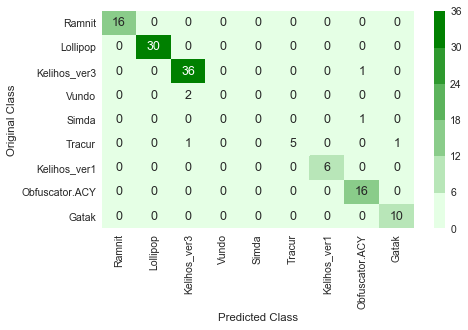

In [405]:
from sklearn.metrics import confusion_matrix
pred1=xgb.predict(X_test)

cf1=confusion_matrix(y_test, pred1)
plot_confusion_matrix(y_test, pred1)